In [1]:
#   Converting Camera Matrix (openCV) to openGl
#   Sources:
#   http://www.info.hiroshima-cu.ac.jp/~miyazaki/knowledge/teche0092.html
#   https://fruty.io/2019/08/29/augmented-reality-with-opencv-and-opengl-the-tricky-projection-matrix/

import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True,
                    formatter={'float_kind': '{:f},'.format})

In [2]:
def compare_projections(point, camera_mtx, opengl_mtx):
    print(point)
    #     
    # screen_point, _ = cv2.projectPoints(np.array([point]), np.zeros(3), np.zeros(3), camera_mtx, np.zeros(5))
    # print(screen_point)

    #Note: we obtain the same result with this: (that's what cv2.projectPoints basically does: multiply points with camera matrix and then divide result by z coord)
    open_cv = camera_mtx.dot(point)/point[2]
    print(open_cv)


    #### OpenGL projection
    #we flip the point z coord, because in opengl camera is oriented along -Oz axis
    point[2] = -point[2]
    point2 = np.hstack([point,1.0]) #we add vertex w coord (usually done in vertex shader before multiplying by projection matrix)
    #we get the point in clip space

    clip_point = opengl_mtx.dot(point2)

    #NOTE: what follows "simulates" what happens in OpenGL after the vertex shader.
    #This is necessary so that we can make sure our projection matrix will yield the correct result when used in OpenGL
    #we get the point in NDC

    ndc_point = clip_point / clip_point[3]
    #we get the screen coordinates
    viewport_point = (ndc_point + 1.0)/2.0 * np.array([w, h, 1.0, 1.0])
    #opencv Oy convention is opposite of OpenGL so we reverse y coord
    viewport_point[1] = h - viewport_point[1]
    
    print(viewport_point)
    print()
    
    

In [7]:
# Camera Matrix (OpenCV)
camera_mtx = np.loadtxt(fname='camera_matrix.txt', delimiter=',')
info =  np.loadtxt(fname='image_info.txt', delimiter=',')

cx = camera_mtx[0][2]
cy = camera_mtx[1][2]

fx = camera_mtx[0][0]
fy = camera_mtx[1][1]

w = info[0]
h = info[1]

near = 1
far = 20

opengl_mtx = np.array([
    [2*fx/w, 0.0, (w - 2*cx)/w, 0.0],
    [0.0, -2*fy/h, (h - 2*cy)/h, 0.0],
    [0.0, 0.0, (-far - near) / (far - near), -2.0*far*near/(far-near)],
    [0.0, 0.0, -1.0, 0.0]
])

np.savetxt(fname='opengl_matrix.txt',X=opengl_mtx, delimiter=',',header='opengl_mtx')


output_file = open('opengl_output.txt', 'w')
output_file.write(str(opengl_mtx) + '\n\n')

print('OpenCV Matrix')
print(camera_mtx, '\n')
print('OpenGL Matrix')
print(opengl_mtx, '\n')
print('Image Properties')
print('width : ',w)
print('height: ',h,'\n')

points = [
    # np.array([0.0, 0.0, 1.0]),
    # np.array([20.0, 40.0, 100.0]),
    # np.array([300.0, 600.0, 1000.0])
    np.array([-1.0, -1.0, 10.0]),
    np.array([1.0, -1.0, 10.0]),
    np.array([1.0, 1.0, 10.0]),
    np.array([-1.0, 1.0, 10.0]),
]

for point in points:
   compare_projections(point=point,camera_mtx=camera_mtx,opengl_mtx=opengl_mtx)



OpenCV Matrix
[[954.402456, 0.000000, 356.109935,]
 [0.000000, 951.810046, 644.814334,]
 [0.000000, 0.000000, 1.000000,]] 

OpenGL Matrix
[[2.651118, 0.000000, 0.010806, 0.000000,]
 [0.000000, -1.487203, -0.007522, 0.000000,]
 [0.000000, 0.000000, -1.105263, -2.105263,]
 [0.000000, 0.000000, -1.000000, 0.000000,]] 

Image Properties
width :  720.0
height:  1280.0 

[-1.000000, -1.000000, 10.000000,]
[260.669690, 549.633330, 1.000000,]
[260.669690, 540.004661, 0.947368, 1.000000,]

[1.000000, -1.000000, 10.000000,]
[451.550181, 549.633330, 1.000000,]
[451.550181, 540.004661, 0.947368, 1.000000,]

[1.000000, 1.000000, 10.000000,]
[451.550181, 739.995339, 1.000000,]
[451.550181, 730.366670, 0.947368, 1.000000,]

[-1.000000, 1.000000, 10.000000,]
[260.669690, 739.995339, 1.000000,]
[260.669690, 730.366670, 0.947368, 1.000000,]



In [4]:
def project_opencv(points, camera_mtx):
    projection = []

    for point in points:
        open_cv = camera_mtx.dot(point)/point[2]
        projection.append([open_cv[0], open_cv[1]])

    return projection
   
def project_opengl(points, opengl_mtx):
    projection = []

    for point in points:
        #### OpenGL projection
        #we flip the point z coord, because in opengl camera is oriented along -Oz axis
        point[2] = -point[2]
        point2 = np.hstack([point,1.0]) #we add vertex w coord (usually done in vertex shader before multiplying by projection matrix)
        #we get the point in clip space
        clip_point = opengl_mtx.dot(point2)

        print(clip_point)

        #NOTE: what follows "simulates" what happens in OpenGL after the vertex shader.
        #This is necessary so that we can make sure our projection matrix will yield the correct result when used in OpenGL
        #we get the point in NDC

        ndc_point = clip_point / clip_point[3]
        #we get the screen coordinates
        viewport_point = (ndc_point + 1.0)/2.0 * np.array([w, h, 1.0, 1.0])
        #opencv Oy convention is opposite of OpenGL so we reverse y coord
        viewport_point[1] = h - viewport_point[1]
        
        # print(viewport_point)
        projection.append([viewport_point[0], viewport_point[1]])
        
    return projection

[0.519418, -0.289918, -1.000000, 1.000000,]
[0.784530, -0.289918, -1.000000, 1.000000,]
[0.784530, -0.438639, -1.000000, 1.000000,]
[0.519418, -0.438639, -1.000000, 1.000000,]


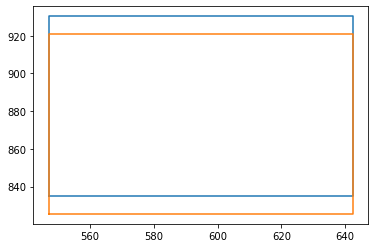

In [5]:
points = [
    # np.array([-0.1, -0.1, 10.0]),
    # np.array([0.1, -0.1, 10.0]),
    # np.array([0.1, 0.1, 10.0]),
    # np.array([-0.1, 0.1, 10.0]),
    np.array([0.2, 0.2, 1.0]),
    np.array([0.3, 0.2, 1.0]),
    np.array([0.3, 0.3, 1.0]),
    np.array([0.2, 0.3, 1.0]),
]

open_cv_projection = project_opencv(points, camera_mtx)
open_gl_projection = project_opengl(points, opengl_mtx)

# print(open_cv_projection[0])
# print(open_cv_projection[1])
# print(open_cv_projection[2])
# print(open_cv_projection[3])
# print()
# print(open_gl_projection[0])
# print(open_gl_projection[1])
# print(open_gl_projection[2])
# print(open_gl_projection[3])

#Draw Shape 


coord = open_cv_projection
coord.append(open_cv_projection[0]) #repeat the first point to create a 'closed loop'

coord1 = open_gl_projection
coord1.append(open_gl_projection[0])

xs, ys = zip(*open_cv_projection) #create lists of x and y values
xs1,ys1 = zip(*open_gl_projection)

plt.figure()
plt.plot(xs,ys) 
plt.plot(xs1,ys1) 

plt.show() # if you need...